# Выбор локации для скважины

Задача: нефтедобывающей компании нужно решить, где бурить новую скважину.

Есть пробы нефти в трёх регионах: качество нефти и объём её запасов. Построим модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль с учетом имеющегося бюджета на разработку месторождений и запасов месторождений, оценим возможные риски техникой Bootstrap.

Шаги:

- Загрузка и предобработка данных. Исследовательский анализ данных о месторождениях в имеющихся регионах.
- Отбор признаков и построение модели машиинного обучения, оценка предсказаний объёма запасов в каждом регионе.
- Выбор месторождений с самым высокими оценками значений запасов.
- Оценка рисков колебаний прибыли в каждом регионе в зависимости от выбора разработки конкретных месторождений.
- Оценка каждого региона с точки зрения прибыльности и рисков.
- Выбор наиболее перспективного региона по результатам проведенного исследования.

## Загрузка и подготовка данных

In [1]:
#импорты из стандартной библиотеки

import warnings

# библиотеки для работы с данными

from math import sqrt
import numpy as np
import pandas as pd
import scipy.stats as st

# библиотеки для визуализации

import matplotlib.pyplot as plt
import plotly.express as px # для построения двойных гистограмм и боксплотов
import plotly.graph_objects as go
import seaborn as sb

# библиотеки для машинного обучения

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

#настройки

# pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.float_format', '{:,.2f}'.format) #формат вывода вещдественных чисел - 2 знака после запятой
warnings.filterwarnings("ignore")

# константы

TOTAL_BUDGET = 10000000            # Бюджет на разработку скважин в регионе (тыс руб)
TOTAL_FIELDS = 500                 # общее число отбираемых скважин с максимальными запасами
N_FIELDS = 200                     # число разраатываемых скважин
PRICE = 450                        # Доход с одной тыс баррелей (тыс руб)
STATE=np.random.RandomState(123)

In [2]:
! gdown --id 1VAeJZAoNIxUI_mpMR-6Y1OS907TY10ea

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1VAeJZAoNIxUI_mpMR-6Y1OS907TY10ea
To: /content/geo_data.zip
100% 12.2M/12.2M [00:00<00:00, 269MB/s]


In [3]:
! unzip /content/geo_data.zip

Archive:  /content/geo_data.zip
  inflating: geo_data_0.csv          
  inflating: geo_data_1.csv          
  inflating: geo_data_2.csv          


In [4]:
try:
    df0 = pd.read_csv('geo_data_0.csv')
    df1 = pd.read_csv('geo_data_1.csv')
    df2 = pd.read_csv('geo_data_2.csv')
except:
    print('Ошибка чтения файла!')

In [5]:
df_list_data = [df0, df1, df2]
df_list_names = ['df0', 'df1', 'df2']

In [6]:
for name, data in zip(df_list_names, df_list_data):
    print('Данные по региону', name)
    display(data.head())
    print('')

Данные по региону df0


,id,f0,f1,f2,product
0,txEyH,0.71,-0.50,1.22,105.28
1,2acmU,1.33,-0.34,4.37,73.04
2,409Wp,1.02,0.15,1.42,85.27
3,iJLyR,-0.03,0.14,2.98,168.62
4,Xdl7t,1.99,0.16,4.75,154.04



Данные по региону df1


,id,f0,f1,f2,product
0,kBEdx,-15.00,-8.28,-0.01,3.18
1,62mP7,14.27,-3.48,1.00,26.95
2,vyE1P,6.26,-5.95,5.00,134.77
3,KcrkZ,-13.08,-11.51,5.00,137.95
4,AHL4O,12.70,-8.15,5.00,134.77



Данные по региону df2


,id,f0,f1,f2,product
0,fwXo0,-1.15,0.96,-0.83,27.76
1,WJtFt,0.26,0.27,-2.53,56.07
2,ovLUW,0.19,0.29,-5.59,62.87
3,q6cA6,2.24,-0.55,0.93,114.57
4,WPMUX,-0.52,1.72,5.90,149.60


In [7]:
for name, data in zip(df_list_names, df_list_data):
    print('Анализ данных по региону', name, end='\n\n')
    display(data.info())
    print('')

Анализ данных по региону df0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None


Анализ данных по региону df1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None


Анализ данных по региону df2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

**Описание данных**.

Данные геологоразведки трёх регионов в таблицах df0, df1, df2 имеют признаки:
* id — уникальный идентификатор скважины (строковый тип, не влияет на результат машинного обучения);
* f0, f1, f2 — три признака точек (числовой тип);
* product — объём запасов в скважине (тыс. баррелей) (числовой тип).

Таким образом, признаки - это f0, f1, f2. Целевой признак - product.

Названия столбцов корректное, не требует обработки.
Необходимые преобразования:
Столбец id тоже не нуждается в обработке, как не особо информативный предлагаю удалить. Пропусков нет. Проверим данные на наличие полных дубликатов.

In [8]:
for name, data in zip(df_list_names, df_list_data):
    #data =
    data.drop(['id'], axis=1, inplace=True)
    print('Данные по региону', name)
    display(data.head())
    print('')

Данные по региону df0


,f0,f1,f2,product
0,0.71,-0.50,1.22,105.28
1,1.33,-0.34,4.37,73.04
2,1.02,0.15,1.42,85.27
3,-0.03,0.14,2.98,168.62
4,1.99,0.16,4.75,154.04



Данные по региону df1


,f0,f1,f2,product
0,-15.00,-8.28,-0.01,3.18
1,14.27,-3.48,1.00,26.95
2,6.26,-5.95,5.00,134.77
3,-13.08,-11.51,5.00,137.95
4,12.70,-8.15,5.00,134.77



Данные по региону df2


,f0,f1,f2,product
0,-1.15,0.96,-0.83,27.76
1,0.26,0.27,-2.53,56.07
2,0.19,0.29,-5.59,62.87
3,2.24,-0.55,0.93,114.57
4,-0.52,1.72,5.90,149.60


In [9]:
for name, data in zip(df_list_names, df_list_data):
    print('Количество полных дубликатов по региону', name)
    print(data.duplicated().sum())
    print('')

Количество полных дубликатов по региону df0
0

Количество полных дубликатов по региону df1
0

Количество полных дубликатов по региону df2
0



In [10]:
for name, data in zip(df_list_names, df_list_data):
    data = data.astype(({'f0':'float32', 'f1':'float32', 'f2':'float32', 'product':'float32'}))#, errors = 'ignore')
    print('Анализ данных по региону', name, 'после преобразования типов', end='\n\n')
    display(data.info())
    print('')

Анализ данных по региону df0 после преобразования типов

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float32
 1   f1       100000 non-null  float32
 2   f2       100000 non-null  float32
 3   product  100000 non-null  float32
dtypes: float32(4)
memory usage: 1.5 MB


None


Анализ данных по региону df1 после преобразования типов

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float32
 1   f1       100000 non-null  float32
 2   f2       100000 non-null  float32
 3   product  100000 non-null  float32
dtypes: float32(4)
memory usage: 1.5 MB


None


Анализ данных по региону df2 после преобразования типов

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float32
 1   f1       100000 non-null  float32
 2   f2       100000 non-null  float32
 3   product  100000 non-null  float32
dtypes: float32(4)
memory usage: 1.5 MB


None

Предобработка проведена успешно. Проведем анализ данных.

In [11]:
for name, data in zip(df_list_names, df_list_data):
    print('Анализ данных по региону', name)
    display(data.describe().T)
    print('')

Анализ данных по региону df0


,count,mean,std,min,25%,50%,75%,max
f0,"100,000.00",0.50,0.87,-1.41,-0.07,0.50,1.07,2.36
f1,"100,000.00",0.25,0.50,-0.85,-0.20,0.25,0.70,1.34
f2,"100,000.00",2.50,3.25,-12.09,0.29,2.52,4.72,16.00
product,"100,000.00",92.50,44.29,0.00,56.50,91.85,128.56,185.36



Анализ данных по региону df1


,count,mean,std,min,25%,50%,75%,max
f0,"100,000.00",1.14,8.97,-31.61,-6.30,1.15,8.62,29.42
f1,"100,000.00",-4.80,5.12,-26.36,-8.27,-4.81,-1.33,18.73
f2,"100,000.00",2.49,1.70,-0.02,1.00,2.01,4.00,5.02
product,"100,000.00",68.83,45.94,0.00,26.95,57.09,107.81,137.95



Анализ данных по региону df2


,count,mean,std,min,25%,50%,75%,max
f0,"100,000.00",0.00,1.73,-8.76,-1.16,0.01,1.16,7.24
f1,"100,000.00",-0.00,1.73,-7.08,-1.17,-0.01,1.16,7.84
f2,"100,000.00",2.50,3.47,-11.97,0.13,2.48,4.86,16.74
product,"100,000.00",95.00,44.75,0.00,59.45,94.93,130.60,190.03


Анализ признака f0 по разным регионам

Анализ данных по региону df0


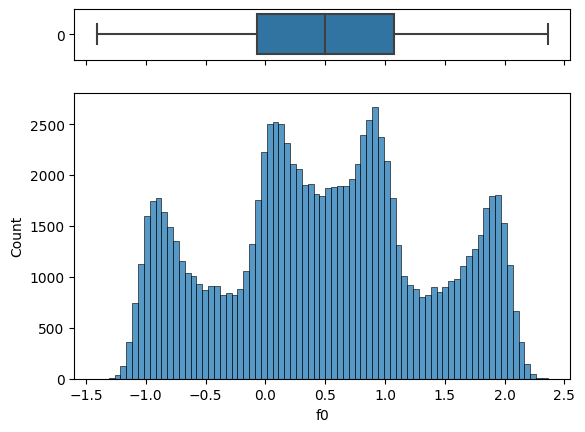

Анализ данных по региону df1


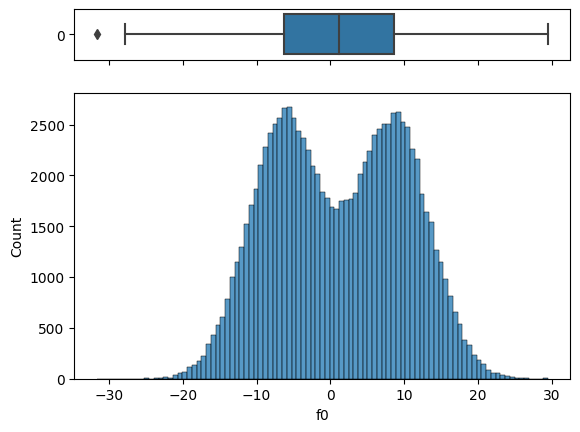

Анализ данных по региону df2


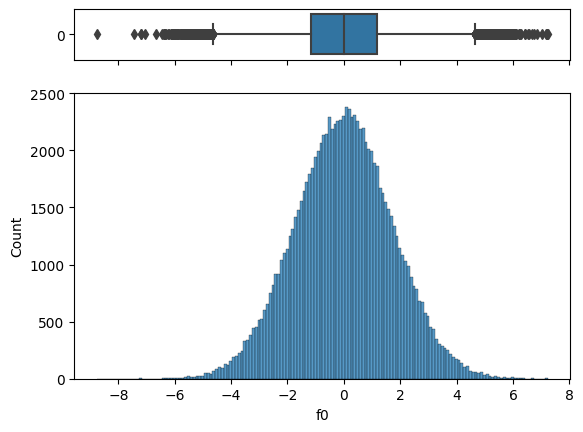

In [12]:
print('Анализ признака f0 по разным регионам', end='\n\n')
for name, data in zip(df_list_names, df_list_data):
    print('Анализ данных по региону', name)
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': (.15, .85)})
    sb.boxplot(data['f0'], ax=ax_box, orient='h')
    sb.histplot(data=data, x='f0', ax=ax_hist)
    plt.show()

Анализ признака f1 по разным регионам

Анализ данных по региону df0


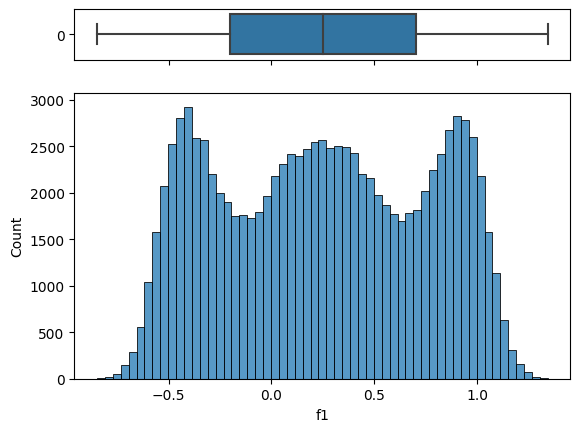

Анализ данных по региону df1


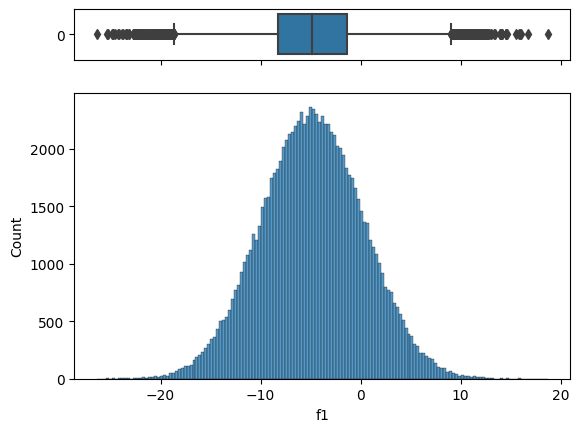

Анализ данных по региону df2


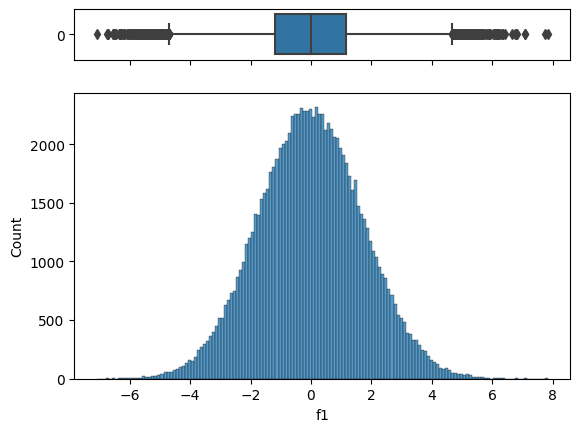

In [13]:
print('Анализ признака f1 по разным регионам', end='\n\n')
for name, data in zip(df_list_names, df_list_data):
    print('Анализ данных по региону', name)
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': (.15, .85)})
    sb.boxplot(data['f1'], ax=ax_box, orient='h')
    sb.histplot(data=data, x='f1', ax=ax_hist)
    plt.show()

Анализ признака f2 по разным регионам

Анализ данных по региону df0


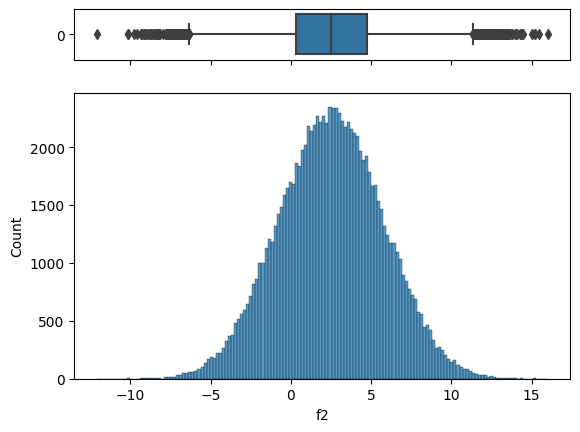

Анализ данных по региону df1


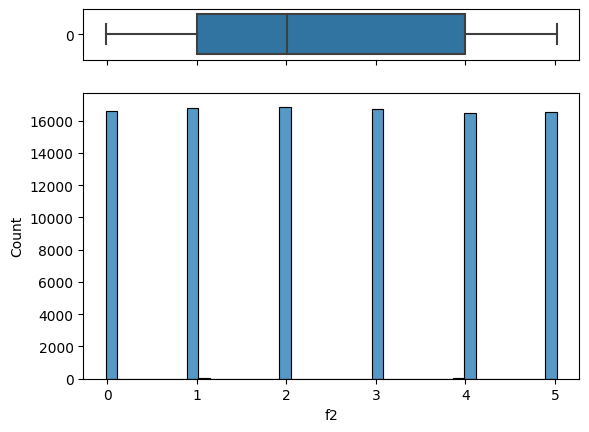

Анализ данных по региону df2


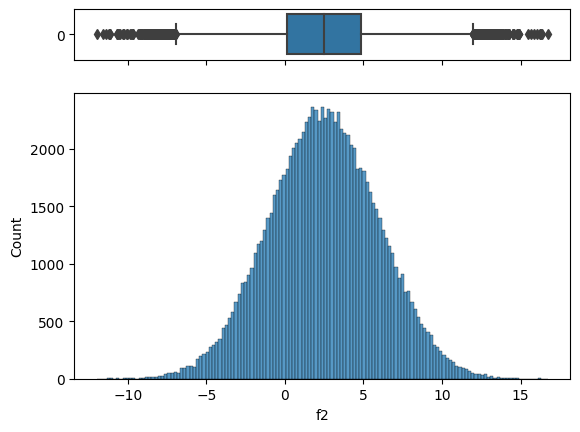

In [14]:
print('Анализ признака f2 по разным регионам', end='\n\n')
for name, data in zip(df_list_names, df_list_data):
    print('Анализ данных по региону', name)
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': (.15, .85)})
    sb.boxplot(data['f2'], ax=ax_box, orient='h')
    sb.histplot(data=data, x='f2', ax=ax_hist)
    plt.show()

Анализ целевого признака по разным регионам

Анализ данных по региону df0


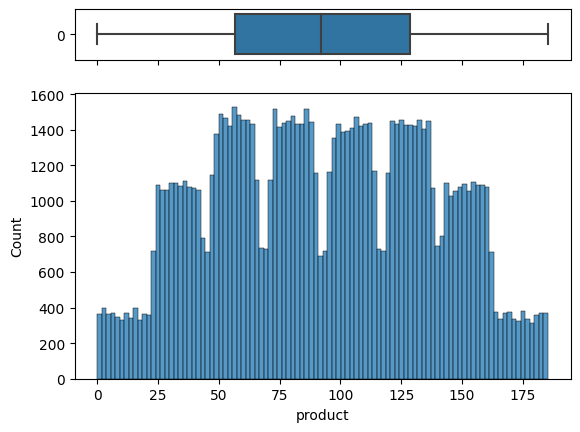

Анализ данных по региону df1


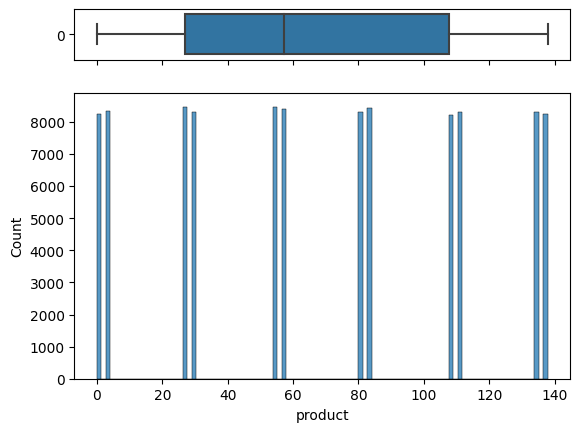

Анализ данных по региону df2


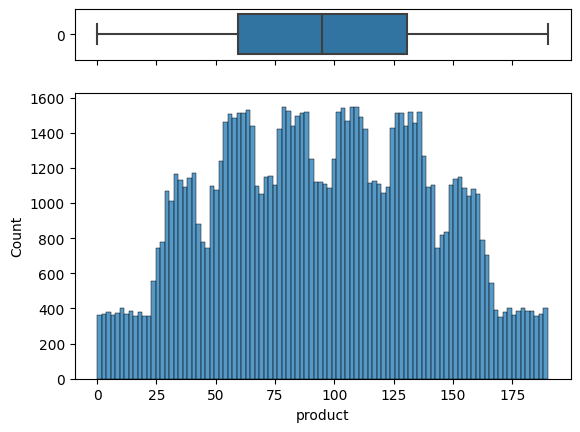

In [15]:
print('Анализ целевого признака по разным регионам', end='\n\n')
for name, data in zip(df_list_names, df_list_data):
    print('Анализ данных по региону', name)
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': (.15, .85)})
    sb.boxplot(data['product'], ax=ax_box, orient='h')
    sb.histplot(data=data, x='product', ax=ax_hist, bins=100)
    plt.show()

Анализ распределений признаков и целевой переменной.

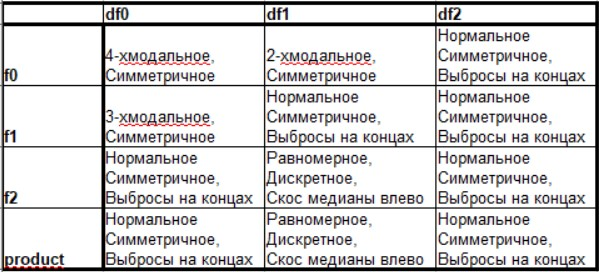

Посмотрим подробнее на регион df1.

In [16]:
df1.groupby('product').agg({'f0': ['count', 'median'], 'f1': ['median'], 'f2': ['mean', 'median']})

f0            f1   f2       
        count median median mean median
product                                
0.00     8235   8.73  -3.67 0.00  -0.00
3.18     8337  -6.35  -6.03 0.00   0.00
26.95    8468   8.71  -3.60 1.00   1.00
30.13    8306  -6.36  -5.87 1.00   1.00
53.91    8472   8.60  -3.67 2.00   2.00
57.09    8390  -6.23  -5.96 2.00   2.00
80.86    8320   8.56  -3.73 3.00   3.00
84.04    8431  -6.23  -6.03 3.00   3.00
107.81   8201   8.58  -3.69 4.00   4.00
110.99   8303  -6.19  -5.91 4.00   4.00
134.77   8304   8.47  -3.77 5.00   5.00
137.95   8233  -6.34  -5.85 5.00   5.00

Интересно, что обьем запасов в скважинах равномерно дискретен через каждые 20 тыс баррелей наблюдаются 2 группы через 4 тыс барр. Распределение похоже на признак f2 по данному региону.

Посмотрим корелляцию признаков по регионам.

In [17]:
for name, data in zip(df_list_names, df_list_data):
    print('Анализ корелляции признаков по региону', name)
    display(data.corr())
    print('\n')

Анализ корелляции признаков по региону df0


,f0,f1,f2,product
f0,1.00,-0.44,-0.00,0.14
f1,-0.44,1.00,0.00,-0.19
f2,-0.00,0.00,1.00,0.48
product,0.14,-0.19,0.48,1.00




Анализ корелляции признаков по региону df1


,f0,f1,f2,product
f0,1.00,0.18,-0.00,-0.03
f1,0.18,1.00,-0.00,-0.01
f2,-0.00,-0.00,1.00,1.00
product,-0.03,-0.01,1.00,1.00




Анализ корелляции признаков по региону df2


,f0,f1,f2,product
f0,1.00,0.00,-0.00,-0.00
f1,0.00,1.00,0.00,-0.00
f2,-0.00,0.00,1.00,0.45
product,-0.00,-0.00,0.45,1.00


Корелляция признаков по разным регионам

Анализ данных по региону df0


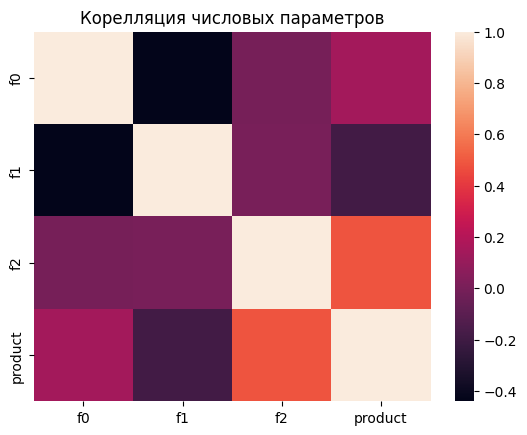

Анализ данных по региону df1


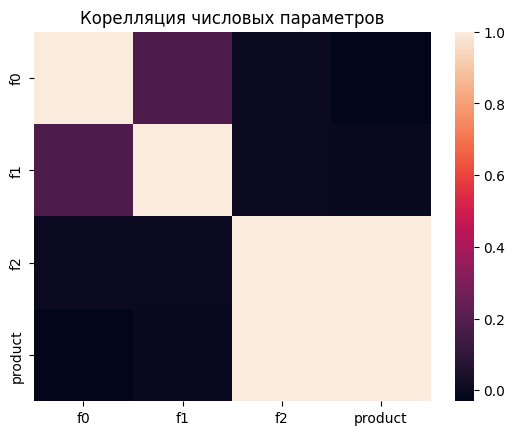

Анализ данных по региону df2


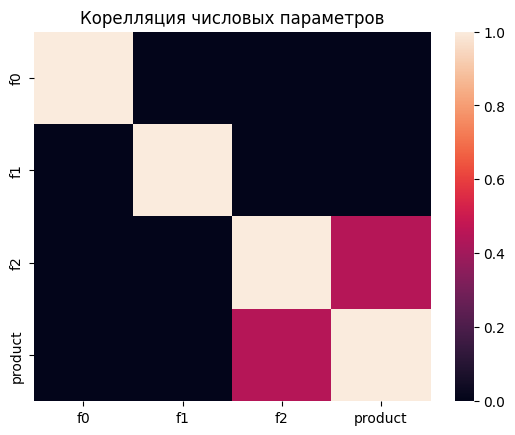

In [18]:
print('Корелляция признаков по разным регионам', end='\n\n')
for name, data in zip(df_list_names, df_list_data):
    print('Анализ данных по региону', name)
#    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': (.15, .85)})
    sb.heatmap(data.corr())
    plt.title('Корелляция числовых параметров')
    plt.show()


Наблюдается незначительная обратная зависимость признаков f1 и f0 в регионе df0. Значительной мультиколлинеарности не наблюдаем. Наибольшее влияние на целевую переменную оказывает признак f2. В регионе df1 это практически 1

## Обучение и проверка модели

In [19]:
scale_features = ['f0', 'f1', 'f2']
scaler = StandardScaler()

In [20]:
def train_model(df):
    features = df.drop('product', axis=1)
    target = df['product']
    features_train, features_valid, target_train, target_valid = train_test_split(
        features,
        target,
        test_size=0.25,
        random_state=STATE,
        shuffle=True)
    features_train = features_train.reset_index(drop=True)
    target_train = target_train.reset_index(drop=True)
    features_valid = features_valid.reset_index(drop=True)
    target_valid = target_valid.reset_index(drop=True)
    scaler.fit(features_train[scale_features])
    features_train_scaled = features_train
    features_train_scaled[scale_features] =  scaler.transform(features_train_scaled[scale_features])
    features_valid_scaled = features_valid
    features_valid_scaled[scale_features] = scaler.transform(features_valid_scaled[scale_features])
    model = LinearRegression()
    model.fit(features_train, target_train)
    predict_valid = model.predict(features_valid)
    predict_valid = pd.Series(predict_valid, index=target_valid.index)
    predict_valid_mean = predict_valid.mean()
    rmse = sqrt(mean_squared_error(target_valid, predict_valid))
    return target_valid, predict_valid, predict_valid_mean, rmse


In [21]:
target_valid_0, predict_valid_0, predict_valid_mean_0, rmse_0 = train_model(df0)
target_valid_1, predict_valid_1, predict_valid_mean_1, rmse_1 = train_model(df1)
target_valid_2, predict_valid_2, predict_valid_mean_2, rmse_2 = train_model(df2)

rmse_region = pd.DataFrame({
    'region': [0, 1, 2],
    'mean_predict': [predict_valid_mean_0, predict_valid_mean_1, predict_valid_mean_2],
    'rmse': [rmse_0, rmse_1, rmse_2]})

rmse_region.set_index('region')
rmse_region

,region,mean_predict,rmse
0,0,92.55,37.65
1,1,69.03,0.89
2,2,95.06,40.02


Наиболее высокий средний запас предсказанного сырья в регионе 2 и 0 на уровне 92,55 и 95,1 тыс барр. При этом квадратный корень из средней квадратичной ошибки rmse в этих регионах тоже значительный 37,7 и 40 тыс барр. В регионе 1 запас не столь высокий 69,03 тыс барр, но и ошибка rmse почти нулевая 0,89.

## Подготовка к расчёту прибыли

### Расчет достаточного обьема сырья для безубыточной разработки новой скважины

In [22]:
budget_field = TOTAL_BUDGET / N_FIELDS   # бюджет на разработку одной скважины

min_product_profit =  budget_field / PRICE # Достаточный обьем сырья для безубыточной разработки новой скважины
print('Достаточный обьем сырья в скважине для безубыточной разработки новой скважины:', np.around(min_product_profit, decimals=2), 'тыс барр')

Достаточный обьем сырья в скважине для безубыточной разработки новой скважины: 111.11 тыс барр


### Сравнение со средним запасом скважин в каждом регионе

К сожалению средние запасы скважин во всех регионах ниже среднего, больше всего отклонение по региону 1: средний запас скважин ниже более чем в 1,5 раза достаточного обьема для безубыточной разработки. В регионах 0 и 2 почти в 1,2 раза меньше, однако и rmse по данным регионам достаточно велик, что говорит о значительных рисках.

## Расчёт прибыли и рисков

Для максимизации прибыли и снижения рисков отберем скважины с максимальным предсказанным обьемом сырья и по ним техникой бутстреп расчитаем 95% доверительный интервал и найдем риск убытков.

Рассчитаем прибыль по отобранным 500 скважинам с максимальными запасами сырья для каждого региона.

In [23]:
def profit(target, predict):
    target_predict = pd.concat([target, predict], axis=1).rename(columns={'product': 'target', 0: 'predict'})
    target_predict = target_predict.sort_values(by='predict', ascending=False)[:200]
    total_profit = np.around((target_predict['target'].sum()*PRICE - TOTAL_BUDGET), decimals=2)
    predict_sort, target_sort = target_predict['predict'], target_predict['target']
    return total_profit, predict_sort, target_sort

In [24]:
profit_0, predict_sort_0, target_sort_0 = profit(target_valid_0, predict_valid_0)
profit_1, predict_sort_1, target_sort_1 = profit(target_valid_1, predict_valid_1)
profit_2, predict_sort_2, target_sort_2 = profit(target_valid_2, predict_valid_2)
print('Для региона 0 прибыль составляет:', profit_0, 'тыс руб')
print('Для региона 1 прибыль составляет:', profit_1, 'тыс руб')
print('Для региона 2 прибыль составляет:', profit_2, 'тыс руб')

Для региона 0 прибыль составляет: 3534670.92 тыс руб
Для региона 1 прибыль составляет: 2415086.7 тыс руб
Для региона 2 прибыль составляет: 2476006.38 тыс руб


Для того, чтобы получить не случайную (максимальную), а приближенную к истинному среднюю прибыль, возьмем 1000раз выборки по 500 скважин из исходного распределения с 200 максимальными предсказанными запасами сырья, найдем в них среднее значение. Для этого применим технику бутстреп.

In [25]:
N_SAMPLES = 1000

def profit_bootstrap(target, predict):
    profit_bootstrap = []
    TG_up200 = []
    for i in range(N_SAMPLES):
        predict_subsample = predict.sample(n=TOTAL_FIELDS, replace=True, random_state=STATE)
        target_subsample = target[predict_subsample.index]#.nlargest(N_FIELDS)
        profit_rrr, predict_sort, target_sort = profit(target_subsample, predict_subsample)
        if target_sort.shape != 200:
            TG_up200.append(target_sort.shape)
        profit_bootstrap.append(profit_rrr) #(target_subsample, predict_subsample)
    TG_up200 = pd.Series(TG_up200)
    print(TG_up200.value_counts(sort=True), len(TG_up200))
    profit_bootstrap = pd.Series(profit_bootstrap)
    profit_bootstrap_mean = profit_bootstrap.mean()
    lower = profit_bootstrap.quantile(q=0.025)
    upper = profit_bootstrap.quantile(q=0.975)
    risk1 = st.percentileofscore(profit_bootstrap, 0)
    risk2 = (profit_bootstrap < 0).mean()
    return profit_bootstrap, profit_bootstrap_mean, lower, upper, risk1, risk2

In [26]:
profit_bootstrap_0, profit_bootstrap_mean_0, lower_0, upper_0, risk1_0, risk2_0 = profit_bootstrap(target_valid_0, predict_valid_0)
profit_bootstrap_1, profit_bootstrap_mean_1, lower_1, upper_1, risk1_1, risk2_1 = profit_bootstrap(target_valid_1, predict_valid_1)
profit_bootstrap_2, profit_bootstrap_mean_2, lower_2, upper_2, risk1_2, risk2_2 = profit_bootstrap(target_valid_2, predict_valid_2)

(200,)    1000
dtype: int64 1000
(200,)    1000
dtype: int64 1000
(200,)    1000
dtype: int64 1000


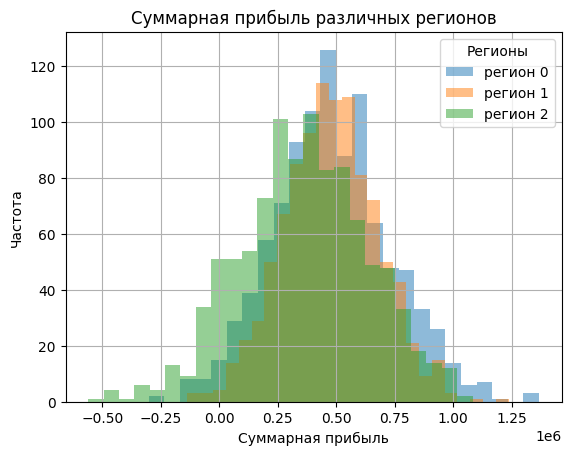

In [27]:
profit_bootstrap_0.hist(bins=25, alpha=0.5)
profit_bootstrap_1.hist(bins=25, alpha=0.5)
profit_bootstrap_2.hist(bins=25, alpha=0.5)
plt.title('Суммарная прибыль различных регионов')
plt.xlabel('Суммарная прибыль')
plt.ylabel('Частота')
plt.legend([
    'регион 0',
    'регион 1',
    'регион 2'], title='Регионы', loc='upper right')
plt.show()

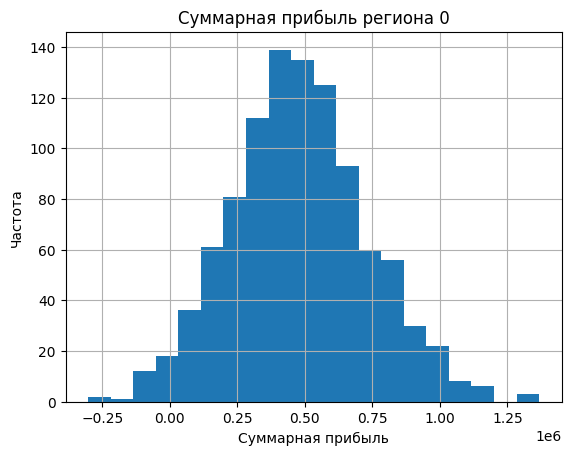

In [28]:
profit_bootstrap_0.hist(bins=20)
plt.title('Суммарная прибыль региона 0')
plt.xlabel('Суммарная прибыль')
plt.ylabel('Частота')
plt.show()

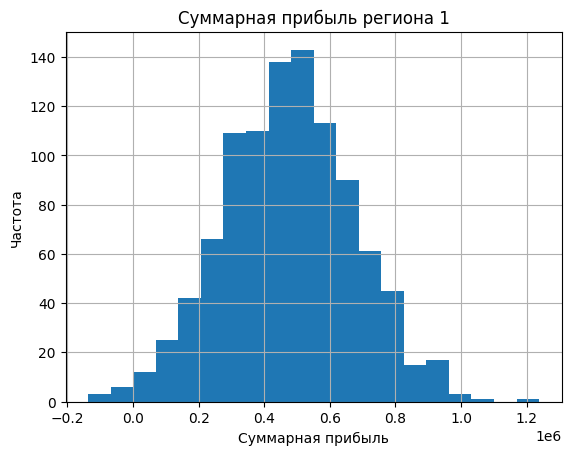

In [29]:
profit_bootstrap_1.hist(bins=20)
plt.title('Суммарная прибыль региона 1')
plt.xlabel('Суммарная прибыль')
plt.ylabel('Частота')
plt.show()

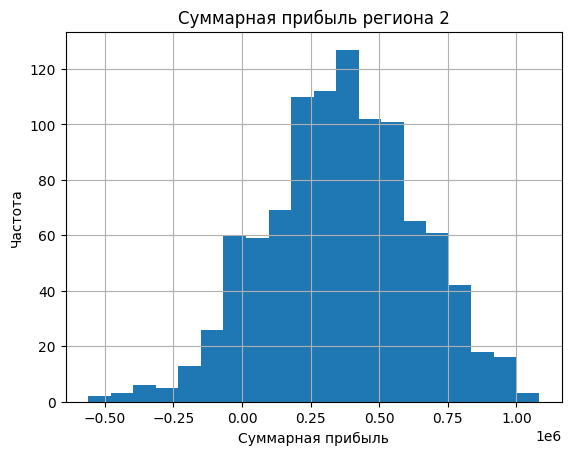

In [30]:
profit_bootstrap_2.hist(bins=20)
plt.title('Суммарная прибыль региона 2')
plt.xlabel('Суммарная прибыль')
plt.ylabel('Частота')
plt.show()

In [31]:
profit_risk_bootstrap = pd.DataFrame({
    'region': [0, 1, 2],
    'mean_profit': [profit_bootstrap_mean_0, profit_bootstrap_mean_1, profit_bootstrap_mean_2],
    'median_profit': [profit_bootstrap_0.median(), profit_bootstrap_1.median(), profit_bootstrap_2.median()],
    'lower': [lower_0, lower_1, lower_2],
    'upper': [upper_0, upper_1, upper_2],
    'risk1': [risk1_0, risk1_1, risk1_2],
    'risk2': [risk2_0, risk2_1, risk2_2]})

profit_risk_bootstrap.set_index('region')
profit_risk_bootstrap

,region,mean_profit,median_profit,lower,upper,risk1,risk2
0,0,"481,224.20","471,420.61","3,130.60","987,708.55",2.30,0.02
1,1,"475,601.73","476,255.70","93,040.98","867,260.95",0.90,0.01
2,2,"363,460.04","365,653.50","-178,959.73","893,479.20",9.80,0.10


**Вывод:**

* Средняя прибыль в регионе geo_1 наибольшая и составляет 475,6 млн руб, 95% доверительный интервал в диапазоне 93-867 млн руб с минимальным уровнем риска убытков 0,9%.
* В регионе geo_2 риск убытков превышает 2,5%, поэтому не рассматриваем его для выбора локации.
* В регионах geo_0 риск убытков составляет 2,3%, средняя прибыль незначительно выше geo_1 и составляет 481,2.

* Таким образом, в качестве рекомендуемой локации для бурения скважин я бы отметила регион geo_1 как менее рискованный, медиана прибыли которого выше, чем у региона geo_0.